# **Phân tích dữ liệu khám phá**

## **Import thư viện cần thiết**

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

## **Dữ liệu**

In [25]:
file_path = "..//data//processed//EUR_VND_Exchange_Rate_2020_2025_clean.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

## **Xu hướng theo thời gian**

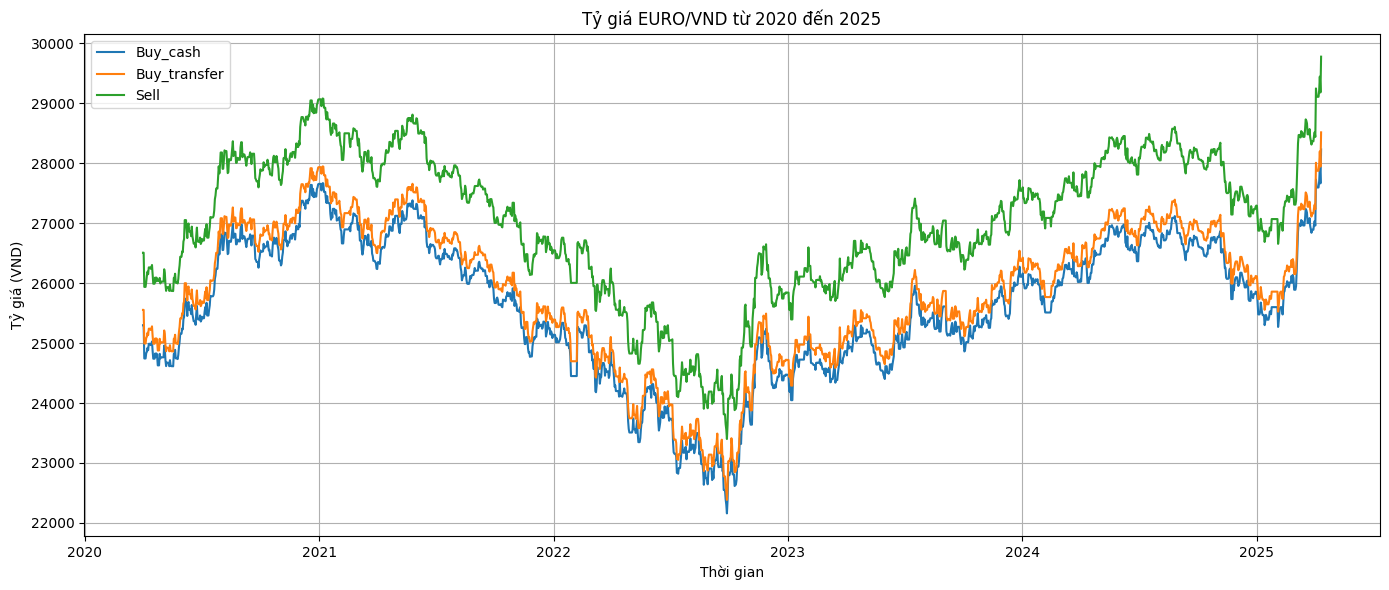

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(df['Buy_cash'], label='Buy_cash')
plt.plot(df['Buy_transfer'], label='Buy_transfer')
plt.plot(df['Sell'], label='Sell')
plt.title("Tỷ giá EURO/VND từ 2020 đến 2025")
plt.xlabel("Thời gian")
plt.ylabel("Tỷ giá (VND)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Phân phối**

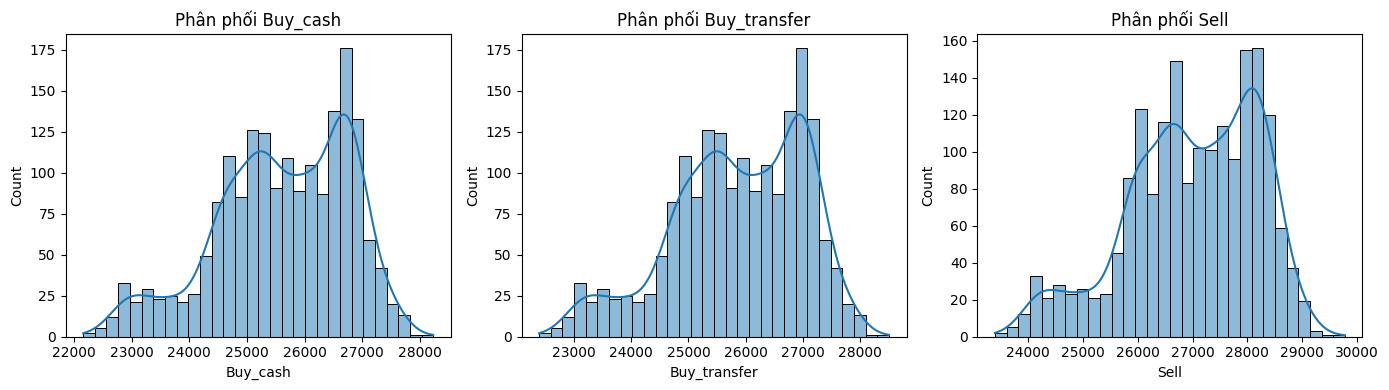

In [27]:
plt.figure(figsize=(14, 4))
for i, col in enumerate(df.columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Phân phối {col}')
plt.tight_layout()
plt.show()


## **Biến động trung bình hàng tháng**

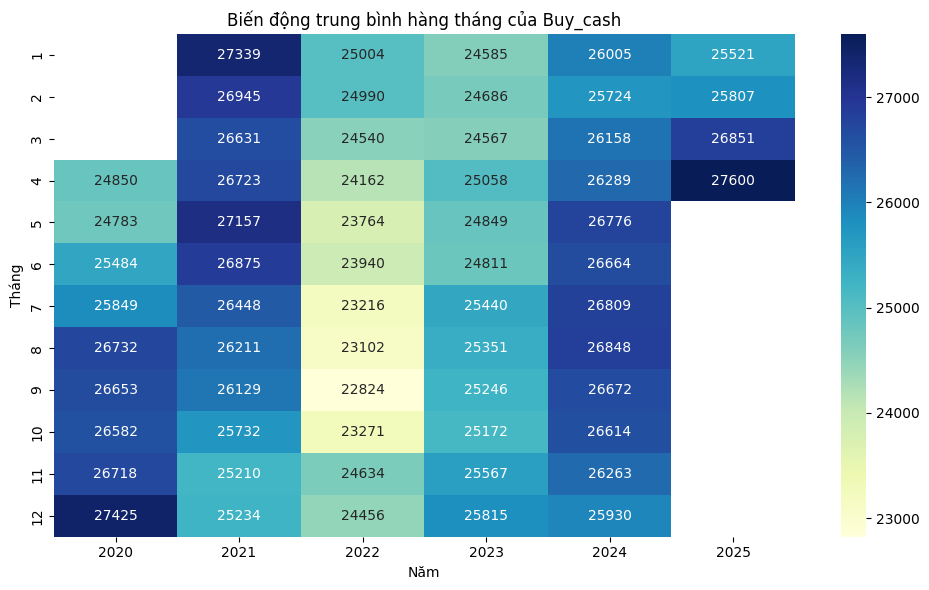

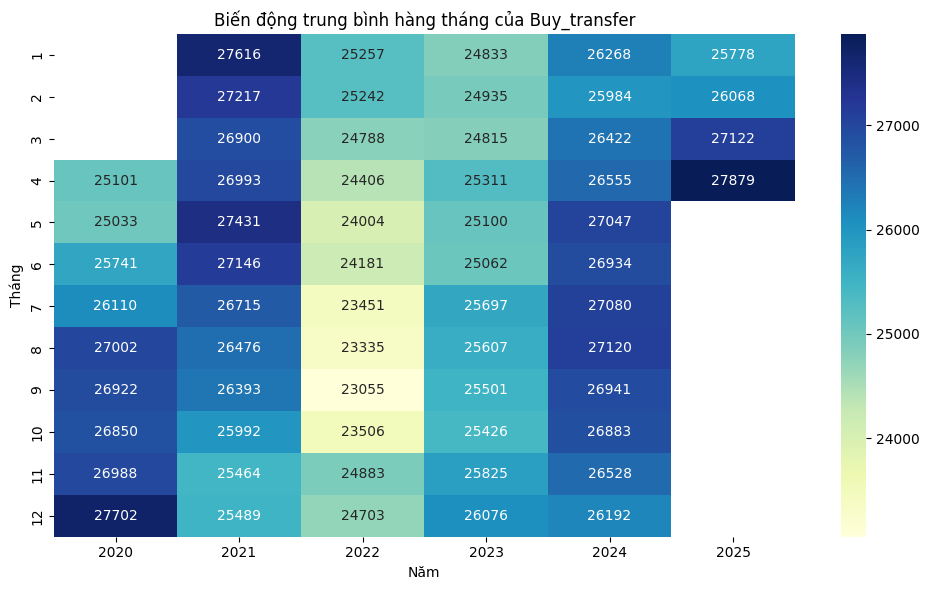

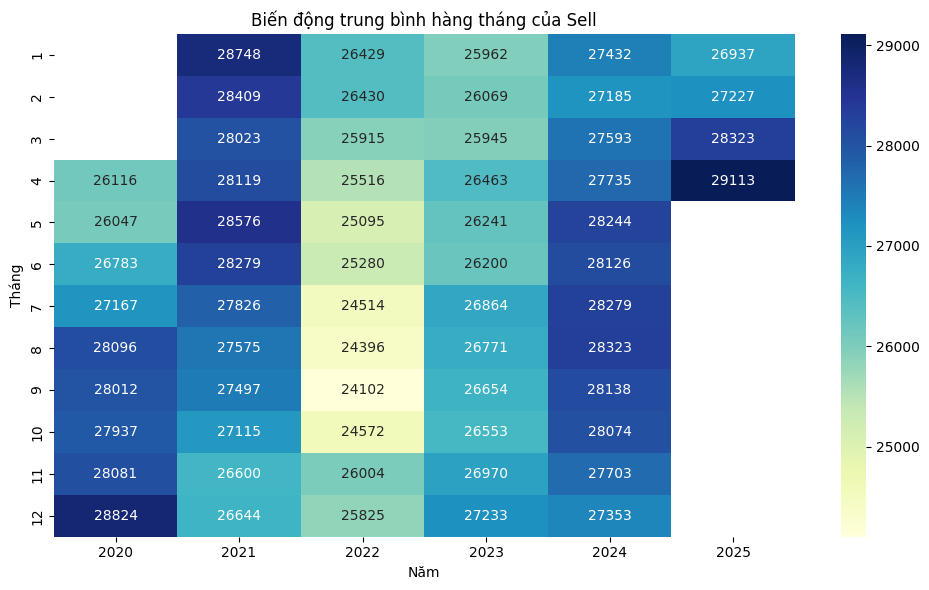

In [28]:
df['Month'] = df.index.month
df['Year'] = df.index.year

# Trung bình hàng tháng
monthly_avg = df.groupby(['Year', 'Month'])[['Buy_cash', 'Buy_transfer', 'Sell']].mean()

# Vẽ heatmap cho từng loại tỷ giá
for col in ['Buy_cash', 'Buy_transfer', 'Sell']:
    pivot_table = monthly_avg[col].unstack(level=0)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title(f'Biến động trung bình hàng tháng của {col}')
    plt.ylabel('Tháng')
    plt.xlabel('Năm')
    plt.tight_layout()
    plt.show()


## **Trung bình theo năm**

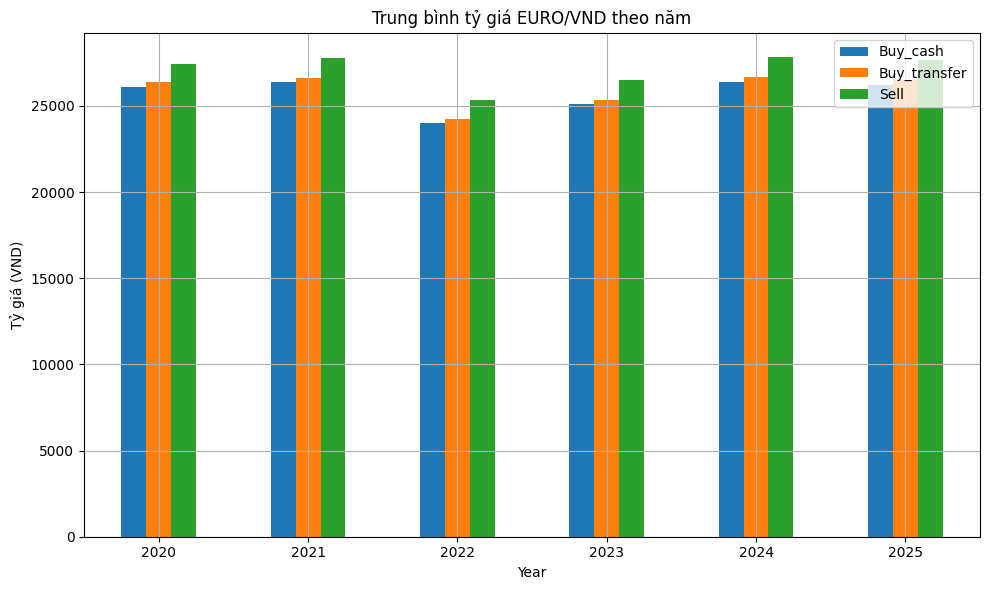

In [29]:
yearly_avg = df.groupby('Year')[['Buy_cash', 'Buy_transfer', 'Sell']].mean()

yearly_avg.plot(kind='bar', figsize=(10, 6))
plt.title('Trung bình tỷ giá EURO/VND theo năm')
plt.ylabel('Tỷ giá (VND)')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


## **Ma trận tương quan**

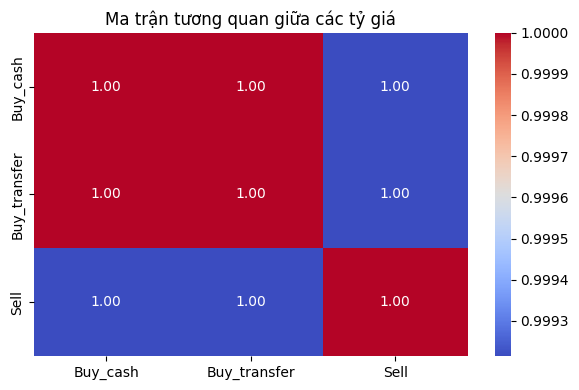

In [32]:
df = df.drop(columns=['Month', 'Year'])
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan giữa các tỷ giá")
plt.tight_layout()
plt.show()


Từ ma trận tương quan giữa ba biến Buy, Transfer và Sell của tỷ giá EUR/VND, có thể thấy rằng các hệ số tương quan đều là 1.00, cho thấy mối quan hệ tuyến tính gần như hoàn hảo giữa các biến. Điều này phản ánh hiện tượng đa cộng
tuyến mạnh, có thể gây sai lệch trong các mô hình dự báo nếu đưa tất cả các biến vào cùng lúc. Vì vậy, để tránh hiện tượng này và đơn giản hoá mô hình, chỉ sử dụng biến Sell làm đại diện trong quá trình dự báo.

## **Tìm điểm ngoại lai**

Số điểm ngoại lai trong 'Sell': 1


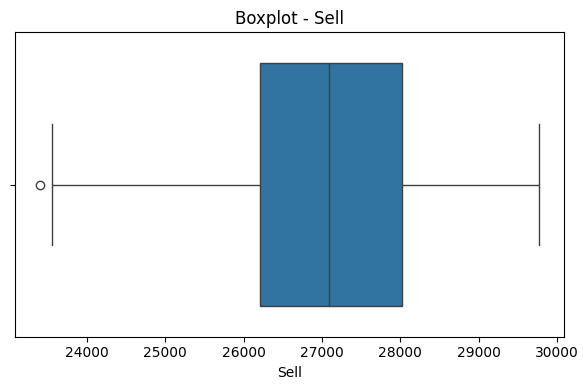

In [33]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[column] < Q1 - 1.5*IQR) | (data[column] > Q3 + 1.5*IQR)]
    return outliers

# Tìm điểm ngoại lai
for col in ['Sell']:
    outliers = detect_outliers_iqr(df, col)
    print(f"Số điểm ngoại lai trong '{col}': {len(outliers)}")

    # Vẽ boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot - {col}')
    plt.tight_layout()
    plt.show()


Biểu đồ tỷ giá EUR/VND cho thấy một điểm ngoại lai duy nhất xuất hiện vào cuối năm 2022, khi tỷ giá giảm sâu bất thường. Tuy nhiên, đây là biến động có nguyên nhân kinh tế rõ ràng, không phải lỗi dữ liệu. Cụ thể, khủng hoảng năng lượng do xung đột Nga–Ukraine, chênh lệch chính sách tiền tệ giữa ECB và Fed, lạm phát cao tại Châu Âu cùng tâm lý thị trường tiêu cực đã khiến đồng Euro suy yếu mạnh so với VND. Do đó, điểm ngoại lai này phản ánh chính xác tình hình thực tế và cần được giữ lại để đảm bảo tính toàn vẹn và khách quan trong phân tích chuỗi thời gian.

## **Kiểm tra tính mùa vụ, xu hướng**

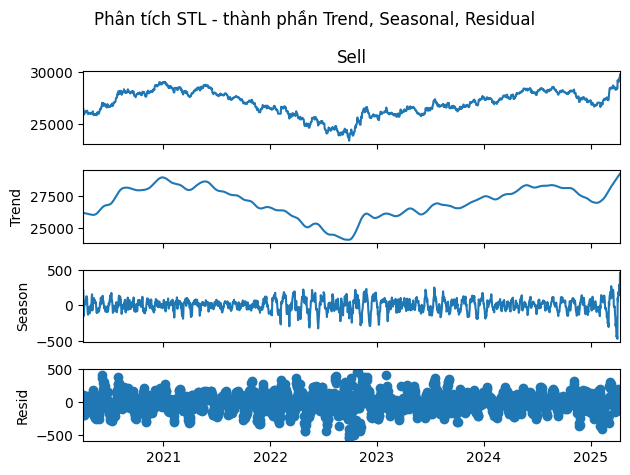

In [35]:
# Chạy STL để phân tích
stl = STL(df['Sell'], period=30)  
res = stl.fit()

# Vẽ các thành phần
res.plot()
plt.suptitle('Phân tích STL - thành phần Trend, Seasonal, Residual')
plt.tight_layout()
plt.show()


- Thành phần gốc: Tỷ giá dao động từ 25,000 đến gần 30,000. Có biến động mạnh giữa năm 2022 (chạm đáy) và đầu 2025 (tăng mạnh trở lại).

- Xu hướng: Giảm từ 2021 đến giữa 2022, sau đó tăng dần đến cuối 2024, phản ánh sự phục hồi tỷ giá.

- Mùa vụ: Dao động nhẹ ±500, có chu kỳ ngắn hạn lặp lại, nhưng ảnh hưởng không đáng kể đến xu hướng tổng thể.

- Phần dư: Biến động ngẫu nhiên, đặc biệt lớn trong 2022–2023, thể hiện tác động từ yếu tố bất thường (kinh tế, chính sách...).

=> Kết luận: Chuỗi có xu hướng phi tuyến và mùa vụ yếu.